In [10]:
import numpy
import numpy as np
import tensorflow.keras as keras
import tensorflow as tf
from importlib import reload
import InputList
import BinaryReader
import Preprocessor
import models
import Callbacks
import TFRecordsHandler
import os

In [195]:
reload(BinaryReader)

<module 'BinaryReader' from '/home/julius/dataspellprojects/oct-classifier/BinaryReader.py'>

In [11]:
data_location = "/mnt/NewHDD/tfrecords"
all_input_files = []
for path, subdirs, files in os.walk(data_location):
    for file in files:
        all_input_files.append(os.path.join(path, file))

In [3]:
all_input_files[0]

'/mnt/NewHDD/tfrecords/0_24012/b6_c0.tfrecords'

In [107]:
def tfrecords_reader(list_of_files, deterministic=False):
    dataset = tf.data.Dataset.from_tensor_slices(list_of_files)
    if not deterministic:
        dataset = dataset.shuffle(len(list_of_files))
    dataset = dataset.interleave(lambda x: tf.data.TFRecordDataset(x),
                                 num_parallel_calls=tf.data.AUTOTUNE,
                                 deterministic=deterministic) \
                      .prefetch(tf.data.AUTOTUNE)
    # pass every single feature through our mapping function
    dataset = dataset.map(
      TFRecordsHandler.parse_tfr_element
    )
    return dataset

In [196]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
reader = BinaryReader.BinaryReader()  # TODO: Normalizer

Num GPUs Available:  1


In [ ]:
training_files, validation_files = reader.split_file_list_for_validation(all_input_files)

In [124]:
training_dataset = tfrecords_reader(training_files)
validation_dataset = tfrecords_reader(validation_files, deterministic=True)

In [100]:
preproc = Preprocessor.Preprocessor(training_dataset)
normalization_layer = preproc.normalize_layer()

In [6]:
a = len(training_files)
b = len(validation_files)
class_weights = {0: (1/b) * (a+b)/2, 1:(1/a) * (a+b)/2}
class_weights

{0: 2.5, 1: 0.625}

In [99]:
normalization_layer
conv = Conv3D(16, 3, activation="relu", padding="same", kernel_initializer=init,
              bias_initializer=binit, kernel_regularizer=keras.regularizers.l1(l1=0.01))(conv)


NameError: name 'normalization_layer' is not defined

In [117]:
# TODO: steps per epoch
BATCH_SIZE = 1
NUM_SAMPLES_TRAIN = len(training_files)
NUM_SAMPLES_VAL = len(validation_files)
CHECKPOINTS = 30
NUM_WALKTHROUGH = 10

model = models.RawClassifier().model()((1536, 102, 102, 1), normalization_layer, reconstruction=False)

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 1536, 102, 102,   0         
                             1)]                                 
                                                                 
 normalization (Normalizatio  (None, 1536, 102, 102, 1  3        
 n)                          )                                   
                                                                 
 conv3d_36 (Conv3D)          (None, 1536, 102, 102, 1  448       
                             6)                                  
                                                                 
 conv3d_37 (Conv3D)          (None, 1536, 102, 102, 1  6928      
                             6)                                  
                                                                 
 max_pooling3d_19 (MaxPoolin  (None, 768, 51, 51, 16)  0   

In [118]:
models.get_model_memory_usage(1, model)

2.794

In [119]:
train_steps=int(NUM_SAMPLES_TRAIN * NUM_WALKTHROUGH / (BATCH_SIZE * CHECKPOINTS))
val_steps=int(NUM_SAMPLES_VAL * NUM_WALKTHROUGH / (BATCH_SIZE * CHECKPOINTS))
print(train_steps, val_steps)

3840 960


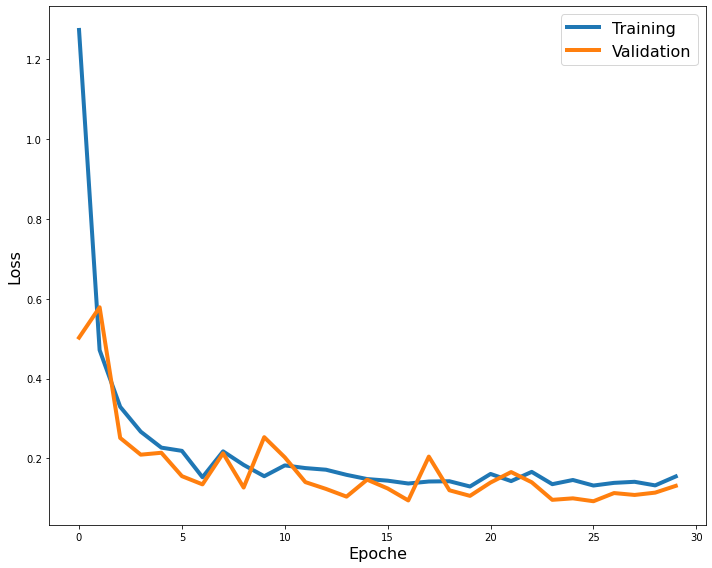

3840/3840 [==============================] - 2069s 539ms/step - loss: 0.1545 - val_loss: 0.1309
INFO:tensorflow:Assets written to: savedModels/first/assets


In [120]:
history = model.fit(
    training_dataset.batch(BATCH_SIZE).repeat(),
    epochs=CHECKPOINTS,
    validation_data=validation_dataset.batch(BATCH_SIZE).repeat(),
    callbacks=Callbacks.my_callbacks,
    class_weight=class_weights,
    use_multiprocessing=True,
    steps_per_epoch= train_steps,
    validation_steps=val_steps
)
model.save('savedModels/first')

In [ ]:
expected = 26133
expected_time = 26133 * 4 # sekunden -> 30 Stunden pro Epoche :(

In [7]:
#normalization_weights = normalization_layer.get_weights()
#print("Before:" + str(normalization_weights))
# normalization_weights_path = "results/normalization.npy"
# #np.save(normalization_weights_path, normalization_weights)
# normalization_layer.set_weights(np.load(normalization_weights_path))
# print("After" + str(normalization_layer.get_weights()))

In [8]:
model.save('savedModels/first_with_all_data')

2022-02-18 09:26:48.837202: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Assets written to: savedModels/first_with_all_data/assets


In [18]:
trained_model = keras.models.load_model('savedModels/first')

(3, 3, 3, 16)


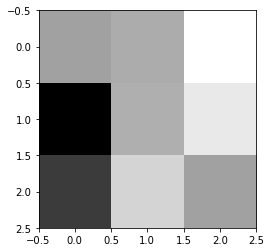

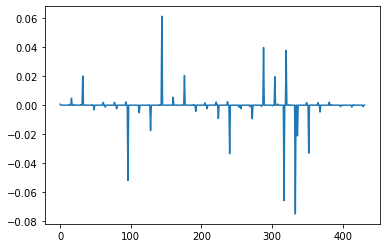

In [149]:
import matplotlib.pyplot as plt
weights_to_plot = model.layers[2].get_weights()[0][:,:,:,0,:]
print(weights_to_plot.shape)
plt.imshow(weights_to_plot[:, :, 0, 0], cmap="Greys")
fig = plt.figure()
plt.plot(weights_to_plot.flatten())

In [153]:
for elem in validation_dataset.take(1):
    print(np.mean(normalization_layer(elem[0])))

-0.006858311


In [220]:
InputList.healthy_training_files[5]

('/mnt/p_Zeiss/Projects/UWF OCTA/Clinical data/MOON1/H3/raw_1536x2048x2045x2_9579.bin',
 0)

In [221]:
test_dataset = reader.create_test_dataset([InputList.healthy_training_files[5]])

In [252]:
val = []
train = []
i = 0
for file in validation_files:
    if file.find("30720") != -1:
        if file.find("b1_") != -1:
            val.append(file)
            print(i)
    i += 1
for file in training_files:
    if file.find("30720") != -1:
        if file.find("b1_") != -1:
            train.append(file)

116
133
249
369
438
570
775
1042
2609


In [253]:
val

['/mnt/NewHDD/tfrecords/1_30720/b1_c6.tfrecords',
 '/mnt/NewHDD/tfrecords/1_30720/b1_c7.tfrecords',
 '/mnt/NewHDD/tfrecords/1_30720/b1_c19.tfrecords',
 '/mnt/NewHDD/tfrecords/1_30720/b1_c3.tfrecords',
 '/mnt/NewHDD/tfrecords/1_30720/b1_c11.tfrecords',
 '/mnt/NewHDD/tfrecords/1_30720/b1_c2.tfrecords',
 '/mnt/NewHDD/tfrecords/1_30720/b1_c0.tfrecords',
 '/mnt/NewHDD/tfrecords/1_30720/b1_c16.tfrecords',
 '/mnt/NewHDD/tfrecords/1_30720/b1_c10.tfrecords']

In [ ]:
test_dataset

In [247]:
test_dataset = tfrecords_reader(['/mnt/NewHDD/tfrecords/1_30720/b1_c0.tfrecords'])

In [249]:
for elem in test_dataset:
    print(elem[1])

tf.Tensor([0], shape=(1,), dtype=int64)


In [229]:
check_set = tfrecords_reader(validation_files, True)

In [230]:
output_test5 = model.predict(
    check_set.batch(1),
    verbose = 1,
    use_multiprocessing=True
)

2880/2880 [==============================] - 643s 223ms/step


In [231]:
output_test5

array([[-13.660425 ],
       [-12.056449 ],
       [-12.290262 ],
       ...,
       [  2.02107  ],
       [-10.346645 ],
       [  2.1178906]], dtype=float32)

In [250]:
test_dataset_healthy = reader.create_test_dataset([InputList.healthy_training_files[-1]])
output_test_healthy = model.predict(
    test_dataset.batch(1),
    verbose = 1,
    use_multiprocessing=True
)

1/1 [==============================] - 0s 292ms/step


In [251]:
output_test_healthy

array([[2.0919182]], dtype=float32)

In [78]:
reshaped_test = np.zeros((20,20))
for file, output in zip(all_input_files[400:800], output_test):
    b_and_c_dim = file.split(".")[0].split("/")[-1].split("_")
    b_dim = b_and_c_dim[0][1:]
    c_dim = b_and_c_dim[1][1:]
    reshaped_test[int(b_dim), int(c_dim)] = output

In [98]:
output_test.shape

(2880, 1)

In [236]:
output_test5[:10]

array([[-13.660425 ],
       [-12.056449 ],
       [-12.290262 ],
       [  2.0876215],
       [-10.84602  ],
       [  2.1266456],
       [  2.0506701],
       [  2.05468  ],
       [  2.014648 ],
       [-11.384293 ]], dtype=float32)

In [241]:
output_test5[:,0].shape

(2880,)

In [254]:
import Postprocessor
labels = []
for elem in validation_dataset:
    labels.append(elem[1])
# for file, output in zip(validation_files, output_test5):
#     labels.append(int(file.split("/")[4][0]))
pp = Postprocessor.Postprocessing(output_test5[:,0], labels)
pp.binary_confusion_matrix()

KeyboardInterrupt: 

In [260]:
labels = [label.numpy() for label in labels]
labels

AttributeError: 'numpy.ndarray' object has no attribute 'numpy'

[[772  24]
 [  0 904]]


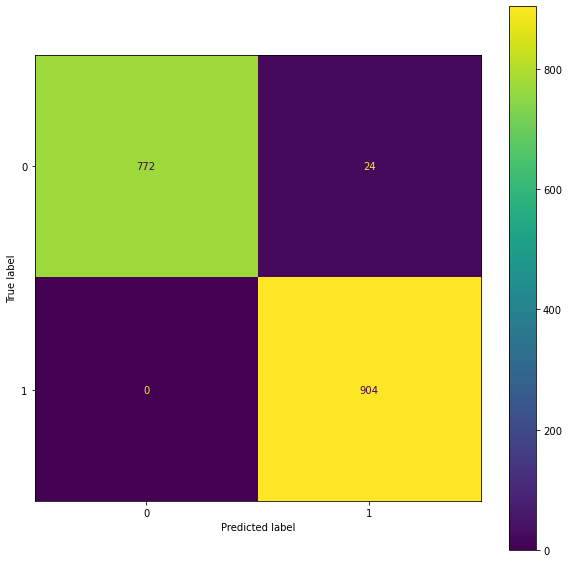

In [266]:
reload(Postprocessor)
pp = Postprocessor.Postprocessing(output_test5[:1700,0], labels[:1700])
pp.binary_confusion_matrix()

In [75]:
b_and_c_dim = file.split(".")[0].split("/")[-1].split("_")
b_dim = b_and_c_dim[0][1:]
c_dim = b_and_c_dim[1][1:]

In [77]:
b_dim, c_dim

('6', '0')

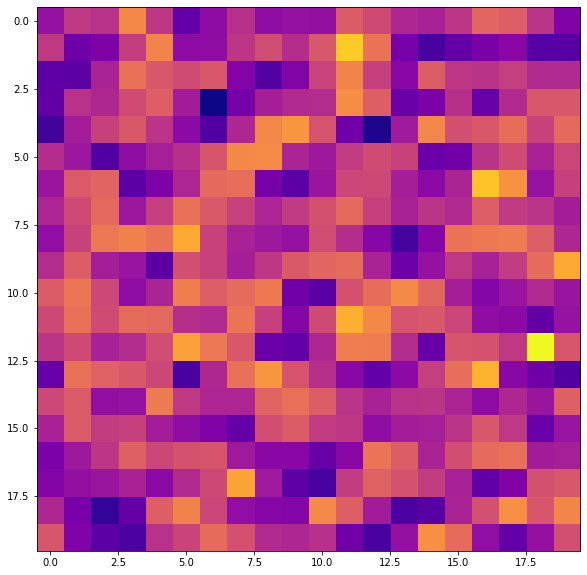

In [206]:
fig = plt.figure(figsize=(20, 10))
plt.imshow(output_test.reshape((20, 20)), cmap="plasma")

In [165]:
import Visualization
reload(Visualization)
vsz = Visualization.ImageVisualizer(output_ensure.reshape((400,1)), instance_size=(102, 102, 20, 20), background_image_path="/mnt/p_Zeiss/Projects/UWF OCTA/Clinical data/MOON1/D113/links/retina_1536x2048x2045x2_30720.png")
vsz.plot_results_map(name="healthy_test2")